# Seattle Police Department Crime Data Analysis - Capstone Project

This notebook presents a comprehensive analysis of Seattle Police Department crime data to understand crime patterns, trends, and factors that influence criminal activity in Seattle.

"## Project Overview
",

### **Dataset Information**
- **Source**: Seattle Police Department Crime Data (2008-Present) + US Census Demographics
- **Size**: 726K+ crime records with census tract demographics (2015-2025)
- **Format**: CSV with 40 variables including temporal, geographic, categorical, and demographic features
- **Coverage**: All reported crimes in Seattle with matched census demographics where available

### **Research Objectives**

This analysis aims to address key questions that can inform evidence-based crime prevention strategies:

#### **1. Analysis - Geographic Crime Patterns**
- **Question**: Where do crimes occur most frequently?
- **Application**: Optimize patrol scheduling, allocate community safety resources, and design location-specific crime prevention strategies
- **Methodology**: Seasonal crime trend analysis, and integration of census demographic data

#### **2. Predictions - Crime Volume Prediction**
- **Question**: How many crimes will occur in this area next month?
- **Application**: Resource allocation, targeted patrol strategies, and proactive deployment based on predictive risk factors
- **Methodology**: Regression modeling using temporal, spatial, demographic, and environmental features

#### **3. Predictions - Crime Category Classification**
- **Question**: What category does this crime belong to?
- **Application**: Automated crime classification and priority response systems
- **Methodology**: Multi-class classification using crime features to predict offense category

### **Expected Outcomes**

**For Law Enforcement:**
- Data-driven patrol routing and scheduling optimization
- Predictive models for resource allocation
- Early warning systems for crime hotspots

**For Community Safety:**
- Risk assessment tools for residents and businesses
- Evidence-based crime prevention recommendations
- Transparency in public safety trends

**For Policy Makers:**
- Statistical insights for policy development
- Cost-effective intervention strategies
- Performance metrics for public safety initiatives

### **Technical Approach**

**Data Pipeline:**
1. **Data Loading & Validation** - Robust data ingestion with quality checks
2. **Exploratory Data Analysis** - Statistical summaries and pattern discovery
3. **Feature Engineering** - Creation of temporal, spatial, and categorical features
4. **Predictive Modeling** - Machine learning models for forecasting and classification
5. **Visualization & Reporting** - Interactive dashboards and analytical insights

---
**Let's begin by loading and exploring the Seattle crime data to understand patterns that can inform public safety decisions.**

In [10]:
# Import required libraries for data analysis and visualization
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Import our custom data loading library
from src.data_loader import (
    load_dataset,            # Load a single CSV dataset
    load_spd_census_joined,  # Load SPD crime data with census demographics
    analyze_data_quality,    # Comprehensive data quality analysis
    prepare_data_for_analysis # Data preparation and cleaning
)

# Configure display options
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# warnings.filterwarnings('ignore')

print("[SUCCESS] Data loader library imported successfully!")
print("Available functions:")
print("  - load_dataset() - Load a single CSV dataset")
print("  - load_spd_census_joined() - Load SPD crime data with census demographics")
print("  - analyze_data_quality() - Comprehensive data quality analysis")
print("  - prepare_data_for_analysis() - Data preparation and cleaning")

[SUCCESS] Data loader library imported successfully!
Available functions:
  - load_dataset() - Load a single CSV dataset
  - load_spd_census_joined() - Load SPD crime data with census demographics
  - analyze_data_quality() - Comprehensive data quality analysis
  - prepare_data_for_analysis() - Data preparation and cleaning


## 1. Data Loading and Initial Exploration

Let's start by loading the SPD Crime dataset enriched with census demographics and examining its structure.

In [11]:
# Load SPD Crime dataset with census demographics using the data loader library
print("Loading SPD Crime Data with Census Demographics...")

# Load the joined SPD Crime and Census dataset
main_df = load_spd_census_joined()

print(f"[SUCCESS] Successfully loaded enriched dataset: spd_census_joined.csv")
print(f"Dataset shape: {main_df.shape}")
print(f"Total records: {main_df.shape[0]:,}")

Loading SPD Crime Data with Census Demographics...
[SUCCESS] Loaded SPD-Census joined dataset: 899,227 records
Records with census demographics: 565,446
Records with geographic coordinates: 767,043
[SUCCESS] Successfully loaded enriched dataset: spd_census_joined.csv
Dataset shape: (899227, 40)
Total records: 899,227
[SUCCESS] Loaded SPD-Census joined dataset: 899,227 records
Records with census demographics: 565,446
Records with geographic coordinates: 767,043
[SUCCESS] Successfully loaded enriched dataset: spd_census_joined.csv
Dataset shape: (899227, 40)
Total records: 899,227


In [12]:
# Rename columns to remove spaces and use underscores
print("Renaming columns to use underscores...")
print(f"Original columns: {len(main_df.columns)} columns")

# Create column mapping dictionary
column_mapping = {}
for col in main_df.columns:
    # First, replace spaces with underscores
    new_col = col.replace(' ', '_')
    
    # Handle camelCase by inserting underscores before capital letters
    # Insert underscore before capital letters that follow lowercase letters or numbers
    new_col = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', new_col)
    
    # Handle multiple consecutive spaces or special characters
    new_col = '_'.join(word for word in new_col.split('_') if word)
    
    # Convert to lowercase for consistency
    new_col = new_col.lower()
    
    column_mapping[col] = new_col

# Rename the columns
main_df = main_df.rename(columns=column_mapping)

print(f"Renamed columns: {len(main_df.columns)} columns")

# Only show changes if there are any
changed_columns = [(old, new) for old, new in column_mapping.items() if old != new]
if changed_columns:
    print(f"Changed {len(changed_columns)} column names:")
    for old_name, new_name in changed_columns:  # Show all changes
        print(f"  '{old_name}' -> '{new_name}'")
else:
    print("No column names needed changing")

print(f"Final column count: {len(main_df.columns)}")

Renaming columns to use underscores...
Original columns: 40 columns
Renamed columns: 40 columns
Changed 34 column names:
  'Report Number' -> 'report_number'
  'Report DateTime' -> 'report_date_time'
  'Offense ID' -> 'offense_id'
  'Offense Date' -> 'offense_date'
  'NIBRS Group AB' -> 'nibrs_group_ab'
  'NIBRS Crime Against Category' -> 'nibrs_crime_against_category'
  'Offense Sub Category' -> 'offense_sub_category'
  'Shooting Type Group' -> 'shooting_type_group'
  'Block Address' -> 'block_address'
  'Latitude' -> 'latitude'
  'Longitude' -> 'longitude'
  'Beat' -> 'beat'
  'Precinct' -> 'precinct'
  'Sector' -> 'sector'
  'Neighborhood' -> 'neighborhood'
  'Reporting Area' -> 'reporting_area'
  'Offense Category' -> 'offense_category'
  'NIBRS Offense Code Description' -> 'nibrs_offense_code_description'
  'NIBRS_offense_code' -> 'nibrs_offense_code'
  'NAME' -> 'name'
  'TotalPopulation' -> 'total_population'
  'MedianHouseholdIncome' -> 'median_household_income'
  'MedianHomeVa

In [13]:
# Quick counts on # of numerical and categorical columns
num_cols = main_df.select_dtypes(include=[np.number]).columns
cat_cols = main_df.select_dtypes(exclude=[np.number]).columns
print(f"\nColumn Type Summary:")
print(f"  Numerical columns: {len(num_cols)}")
print(f"  Categorical columns: {len(cat_cols)}")
print(f"  Total columns: {len(main_df.columns)}")
print(f"\n[INFO] Detailed column analysis follows below...")



Column Type Summary:
  Numerical columns: 23
  Categorical columns: 17
  Total columns: 40

[INFO] Detailed column analysis follows below...


In [14]:
# Examine the main dataset structure
# Basic info
print(f"Shape: {main_df.shape}")
print(f"Memory: {main_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Columns: {list(main_df.columns)}")

# Convert all redacted values to null
main_df.replace(to_replace='REDACTED', value=np.nan, inplace=True)
main_df.replace(to_replace='-', value=np.nan, inplace=True)

# Convert coordinate columns to numeric (this will also handle -1.0 replacement better)
main_df['latitude'] = pd.to_numeric(main_df['latitude'], errors='coerce')
main_df['longitude'] = pd.to_numeric(main_df['longitude'], errors='coerce')

# Replace -1.0 values in coordinate columns (now they're numeric)
main_df.replace(to_replace={'latitude': -1.0, 'longitude': -1.0}, value=np.nan, inplace=True)

# Convert date columns to datetime for filtering
main_df['offense_date'] = pd.to_datetime(main_df['offense_date'], errors='coerce')
main_df['report_date_time'] = pd.to_datetime(main_df['report_date_time'], errors='coerce')

# Extract year, month, day and time from the offense date time, report date time
main_df['offense_year'] = main_df['offense_date'].dt.year
main_df['offense_month'] = main_df['offense_date'].dt.month
main_df['offense_day'] = main_df['offense_date'].dt.day
main_df['offense_hour'] = main_df['report_date_time'].dt.hour

main_df['report_year'] = main_df['report_date_time'].dt.year
main_df['report_month'] = main_df['report_date_time'].dt.month
main_df['report_day'] = main_df['report_date_time'].dt.day
main_df['report_hour'] = main_df['report_date_time'].dt.hour

# Data types summary
print(f"\nData Types:")
type_counts = main_df.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"   {dtype}: {count} columns")

# Display random sample of rows for better data exploration
print(f"\nRandom sample of 3 records:")
# Temporarily adjust pandas display options to show all columns
with pd.option_context('display.max_columns', None, 'display.width', None, 'display.max_colwidth', 50):
    display(main_df.sample(n=3, random_state=42))

print(f"\n" + "="*60)
print(f"DETAILED COLUMN ANALYSIS")
print(f"="*60)

# Quick stats for meaningful numerical columns (exclude IDs)
numerical_cols = main_df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print(f"\nNumerical columns ({len(numerical_cols)}):")
    for col in numerical_cols:
            print(f"   - {col}:")
            print(f"     Count: {main_df[col].count():,}")
            print(f"     Unique: {main_df[col].nunique():,}")
            print(f"     Mean: {main_df[col].mean():.2f}")
            print(f"     Std Dev: {main_df[col].std():.2f}")
            print(f"     Min: {main_df[col].min()}")
            print(f"     Max: {main_df[col].max()}")
            sample_vals = main_df[col].dropna().unique()[:5]
            print(f"     Sample values: {', '.join(map(str, sample_vals))}")

# Print unique values for categorical columns
categorical_cols = main_df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"\nCategorical columns ({len(categorical_cols)}):")
    for col in categorical_cols:
        print(f"   - {col}:")
        print(f"     Unique: {main_df[col].nunique():,}")
        sample_vals = main_df[col].dropna().unique()[:5]
        print(f"     Sample values: {', '.join(map(str, sample_vals))}")

Shape: (899227, 40)


Memory: 976.4 MB
Columns: ['report_number', 'report_date_time', 'offense_id', 'offense_date', 'nibrs_group_ab', 'nibrs_crime_against_category', 'offense_sub_category', 'shooting_type_group', 'block_address', 'latitude', 'longitude', 'beat', 'precinct', 'sector', 'neighborhood', 'reporting_area', 'offense_category', 'nibrs_offense_code_description', 'nibrs_offense_code', 'crime_year', 'tract_geoid', 'name', 'total_population', 'median_household_income', 'median_home_value', 'total_race_ethnicity_pop', 'not_hispanic_latino', 'white_alone', 'black_african_american_alone', 'american_indian_alaska_native_alone', 'asian_alone', 'native_hawaiian_pacific_islander_alone', 'some_other_race_alone', 'two_or_more_races', 'hispanic_latino', 'state', 'county', 'tract', 'geoid', 'census_year']

Data Types:
   float64: 21 columns
   object: 15 columns
   int32: 8 columns
   datetime64[ns]: 2 columns
   int64: 2 columns

Random sample of 3 records:

Data Types:
   float64: 21 columns
   object: 15 colum

,report_number,report_date_time,offense_id,offense_date,nibrs_group_ab,nibrs_crime_against_category,offense_sub_category,shooting_type_group,block_address,latitude,longitude,beat,precinct,sector,neighborhood,reporting_area,offense_category,nibrs_offense_code_description,nibrs_offense_code,crime_year,tract_geoid,name,total_population,median_household_income,median_home_value,total_race_ethnicity_pop,not_hispanic_latino,white_alone,black_african_american_alone,american_indian_alaska_native_alone,asian_alone,native_hawaiian_pacific_islander_alone,some_other_race_alone,two_or_more_races,hispanic_latino,state,county,tract,geoid,census_year,offense_year,offense_month,offense_day,offense_hour,report_year,report_month,report_day,report_hour
323737,2023-247827,2023-08-27 20:41:35,52035314595,2023-08-27 18:30:00,A,PERSON,ASSAULT OFFENSES,NaN,NaN,NaN,NaN,S2,South,S,BRIGHTON/DUNLAP,NaN,ALL OTHER,Intimidation,13C,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,8,27,20,2023,8,27,20
678332,2018-903928,2018-05-04 10:59:00,7638254238,2018-05-01 21:00:00,A,PROPERTY,LARCENY-THEFT,NaN,1XX BLOCK OF NE 64TH ST,47.675152,-122.326808,J3,North,J,ROOSEVELT/RAVENNA,4359,PROPERTY CRIME,Theft From Motor Vehicle,23F,2018,5.303300e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,5,1,10,2018,5,4,10
629568,2016-122426,2016-04-09 10:19:00,7669512605,2016-04-09 10:19:00,A,PROPERTY,ROBBERY,NaN,STEWART ST / 4TH AVE,47.612294,-122.338732,M2,West,M,NaN,2358,VIOLENT CRIME,Robbery,120,2016,5.303301e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,4,9,10,2016,4,9,10



DETAILED COLUMN ANALYSIS

Numerical columns (31):
   - offense_id:
     Count: 899,227
     Unique: 899,227
     Mean: 23863994700.31
     Std Dev: 19715868237.62
     Min: 7624428948
     Max: 65150087987
     Sample values: 7686908546, 20581257360, 7632107337, 7680836165, 37209290681
   - latitude:
     Count: 727,215

Numerical columns (31):
   - offense_id:
     Count: 899,227
     Unique: 899,227
     Mean: 23863994700.31
     Std Dev: 19715868237.62
     Min: 7624428948
     Max: 65150087987
     Sample values: 7686908546, 20581257360, 7632107337, 7680836165, 37209290681
   - latitude:
     Count: 727,215
     Unique: 47,193
     Mean: 47.64
     Std Dev: 0.92
     Min: 0.0
     Max: 89.99998854
     Sample values: 47.609782, 47.58401228, 47.58025275, 47.52102758, 47.58412339
   - longitude:
     Count: 727,215
     Unique: 92,897
     Mean: -122.28
     Std Dev: 3.33
     Min: -174.313026438467
     Max: 175.531030004185
     Sample values: -122.339358, -122.388758487018, -122.

## 2. Data Quality Assessment

Let's examine the data quality, identify potential issues, and understand the key variables in our SPD Crime dataset.

In [15]:
# Comprehensive data quality analysis
quality_report = analyze_data_quality(main_df)

# Display missing values details if any exist
if quality_report['missing_values']:
    print(f"\nMISSING VALUES DETAILS:")
    missing_data = []
    for col, info in quality_report['missing_values'].items():
        missing_data.append({
            'Column': col,
            'Missing Count': info['count'],
            'Missing %': info['percentage']
        })
    missing_df = pd.DataFrame(missing_data)
    display(missing_df.sort_values('Missing %', ascending=False))
else:
    print(f"\n[SUCCESS] No missing values found in the dataset!")
    
# Note: Detailed column analysis is shown in the previous cell to avoid duplication

Shape: (899227, 48)
Duplicates: 0
Missing values: 33 columns affected

MISSING VALUES DETAILS:


,Column,Missing Count,Missing %
2,shooting_type_group,891294,99.12
16,median_household_income,333781,37.12
25,some_other_race_alone,333781,37.12
19,not_hispanic_latino,333781,37.12
20,white_alone,333781,37.12
21,black_african_american_alone,333781,37.12
22,american_indian_alaska_native_alone,333781,37.12
23,asian_alone,333781,37.12
24,native_hawaiian_pacific_islander_alone,333781,37.12
26,two_or_more_races,333781,37.12


In [16]:
# Prepare data for analysis
print("Preparing data for analysis...")
print(f"Input shape: {main_df.shape}")

prepared_df = prepare_data_for_analysis(main_df)

# Summary of changes
rows_removed = main_df.shape[0] - prepared_df.shape[0]
print(f"\nPREPARATION SUMMARY:")
print(f"   Original: {main_df.shape[0]:,} rows")
print(f"   Final: {prepared_df.shape[0]:,} rows")
print(f"   Removed: {rows_removed:,} rows ({rows_removed/main_df.shape[0]*100:.2f}%)")

# Check date columns conversion - all date/time columns in dataset
date_cols = ['report_date_time', 'offense_date']  # All actual date/time columns

if date_cols:
    print(f"\nDATE COLUMNS PROCESSED ({len(date_cols)} columns):")
    for col in date_cols:
        if pd.api.types.is_datetime64_any_dtype(prepared_df[col]):
            date_range = prepared_df[col].dropna()
            if len(date_range) > 0:
                print(f"   [SUCCESS] {col}: {date_range.min()} to {date_range.max()}")
            else:
                print(f"   [WARNING] {col}: No valid dates found")
        else:
            print(f"   [ERROR] {col}: Conversion failed")

print(f"\n[SUCCESS] Dataset ready for analysis with {prepared_df.shape[0]:,} records!")

Preparing data for analysis...
Input shape: (899227, 48)

PREPARATION SUMMARY:
   Original: 899,227 rows
   Final: 899,227 rows
   Removed: 0 rows (0.00%)

DATE COLUMNS PROCESSED (2 columns):
   [SUCCESS] report_date_time: 2015-01-01 00:04:00 to 2025-07-27 00:28:48
   [SUCCESS] offense_date: 2015-01-01 00:00:00 to 2025-07-26 23:00:00

[SUCCESS] Dataset ready for analysis with 899,227 records!

PREPARATION SUMMARY:
   Original: 899,227 rows
   Final: 899,227 rows
   Removed: 0 rows (0.00%)

DATE COLUMNS PROCESSED (2 columns):
   [SUCCESS] report_date_time: 2015-01-01 00:04:00 to 2025-07-27 00:28:48
   [SUCCESS] offense_date: 2015-01-01 00:00:00 to 2025-07-26 23:00:00

[SUCCESS] Dataset ready for analysis with 899,227 records!


## Data Analysis

Text(0.5, 1.0, 'Offense Counts by Year')

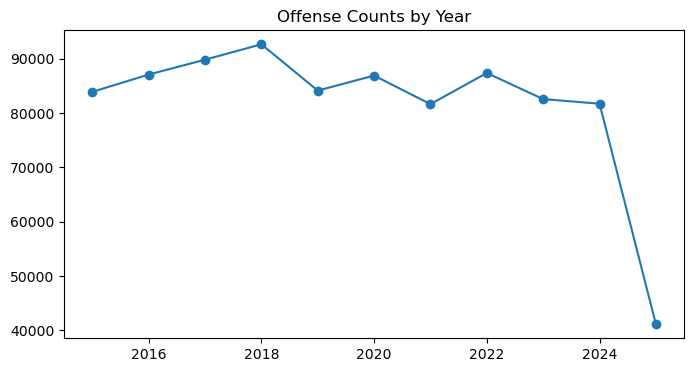

In [17]:
# Plotting example: Offense counts by year (line chart)
plt.figure(figsize=(8, 4))
plt.plot(prepared_df['offense_year'].value_counts().sort_index(), marker='o')
plt.title('Offense Counts by Year')

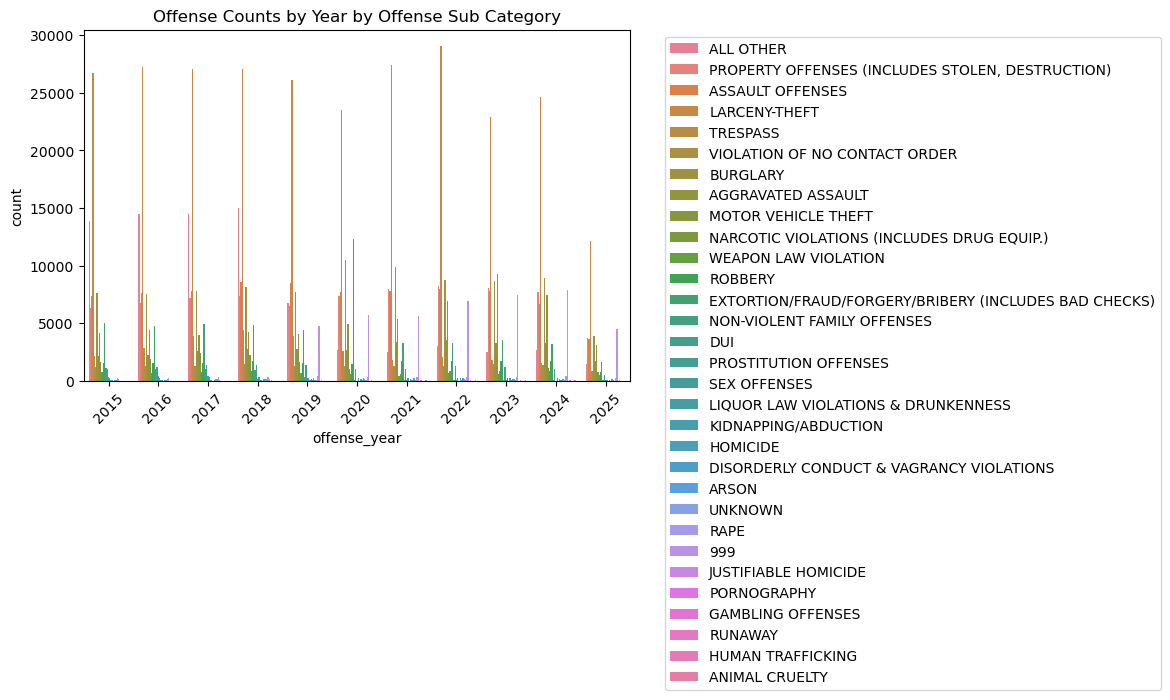

In [18]:
# Plotting example: Offense counts by year by offense sub category (bar chart)
plt.figure(figsize=(12, 6))
sns.countplot(data=prepared_df, x='offense_year', hue='offense_sub_category')
plt.title('Offense Counts by Year by Offense Sub Category')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()